### Kaggle Link
https://www.kaggle.com/c/kkbox-churn-prediction-challenge

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime

sns.set(style='whitegrid')

pd.set_option('display.max_columns', None)  

%matplotlib inline

In [2]:
parser = lambda x : pd.to_datetime(x, errors='coerce')

df_train = pd.read_csv('../Data/Kaggle/Churn/train.csv')
df_members = pd.read_csv('../Data/Kaggle/Churn/members.csv',
                         parse_dates=['registration_init_time', 'expiration_date'], date_parser=parser)
df_transactions = pd.read_csv('../Data/Kaggle/Churn/transactions.csv', 
                              parse_dates=['transaction_date', 'membership_expire_date'], date_parser=parser)
df_user_logs = pd.read_csv('../Data/Kaggle/Churn/user_logs.csv')

df_test = pd.read_csv('../Data/Kaggle/Churn/sample_submission_zero.csv')

### Tables

##### train.csv: the train set, containing the user ids and whether they have churned.
    - msno: user id
    - is_churn: This is the target variable. Churn is defined as whether the user did not continue the subscription within 30 days of expiration. is_churn = 1 means churn,is_churn = 0 means renewal.
    
##### user_logs.csv: daily user logs describing listening behaviors of a user. Data collected until 2/28/2017.
    - msno: user id
    - date: format %Y%m%d
    - num_25: # of songs played less than 25% of the song length
    - num_50: # of songs played between 25% to 50% of the song length
    - num_75: # of songs played between 50% to 75% of of the song length
    - num_985: # of songs played between 75% to 98.5% of the song length
    - num_100: # of songs played over 98.5% of the song length
    - num_unq: # of unique songs played
    - total_secs: total seconds played

##### transactions.csv: transactions of users up until 2/28/2017.
    - msno: user id
    - payment_method_id: payment method
    - payment_plan_days: length of membership plan in days
    - plan_list_price: in New Taiwan Dollar (NTD)
    - actual_amount_paid: in New Taiwan Dollar (NTD)
    - is_auto_renew
    - transaction_date: format %Y%m%d
    - membership_expire_date: format %Y%m%d
    - is_cancel: whether or not the user canceled the membership in this transaction.  
    
##### members.csv: user information. Note that not every user in the dataset is available.
    - msno
    - city
    - bd: age. Note: this column has outlier values ranging from -7000 to 2015, please use your judgement.
    - gender
    - registered_via: registration method
    - registration_init_time: format %Y%m%d
    - expiration_date: format %Y%m%d

In [3]:
df_transactions = df_transactions.sort_values(by=['transaction_date'], ascending=[False]).reset_index(drop=True)
df_transactions = df_transactions.drop_duplicates(subset=['msno'], keep='first')
df_transactions.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,v9qq9up34ELNaGex7Yl0CvqwnRbh3qYgIu791AZN16s=,41,30,99,99,1,2017-02-28,2017-03-31,0
1,gxDtfzWgv9f2efeTFZfasyzjoO+xLwvrM501RcU8uZU=,40,30,149,149,1,2017-02-28,2017-03-27,0
2,wnanA7wQWo2kRKHJ+EAcAhllu7owvS3RbD7GvGUOWvY=,41,30,99,99,1,2017-02-28,2017-03-31,0
3,3+ECUXPd2GZYiniQMrRHzYLqQZ5LwsKYkrktEbGd4Wo=,41,30,99,99,1,2017-02-28,2017-03-31,0
4,OJwA/1avEFnk5nIWjSWmFYJU25o+Q+RMvaWiAXGKVQU=,41,30,99,99,1,2017-02-28,2017-03-31,0


### Merging

#### Train

In [7]:
df_train = df_train.merge(df_members, how='left', on=['msno'])
df_train.head()

,msno,is_churn,city_x,bd_x,gender_x,registered_via_x,registration_init_time_x,expiration_date_x,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,average_num_25,average_num_50,average_num_75,average_num_985,average_num_unq,average_total_secs,city_y,bd_y,gender_y,registered_via_y,registration_init_time_y,expiration_date_y
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,18.0,36.0,female,9.0,2005-04-06,2017-09-07,38,30,149,149,0,2017-01-07,2017-02-06,0,1.961538,0.615385,0.730769,0.423077,15.730769,17.769231,18.0,36.0,female,9.0,2005-04-06,2017-09-07
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,10.0,38.0,male,9.0,2005-04-07,2017-03-21,39,30,149,149,1,2017-02-24,2017-03-21,1,0.857965,0.301344,0.232246,0.341651,19.082534,13.880998,10.0,38.0,male,9.0,2005-04-07,2017-03-21
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,11.0,27.0,female,9.0,2005-10-16,2017-02-03,39,30,149,149,1,2017-01-12,2017-02-03,1,6.624473,4.008439,1.274262,2.021097,42.333333,48.662447,11.0,27.0,female,9.0,2005-10-16,2017-02-03
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,13.0,23.0,female,9.0,2005-11-02,2017-09-26,38,410,1788,1788,0,2016-01-06,2017-02-20,0,9.884354,3.292517,2.434014,2.223129,24.585034,25.141497,13.0,23.0,female,9.0,2005-11-02,2017-09-26
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1,3.0,27.0,male,9.0,2005-12-28,2017-09-27,38,30,149,149,0,2017-01-28,2017-02-27,0,1.832454,0.941953,0.899736,4.258575,90.674142,95.875989,3.0,27.0,male,9.0,2005-12-28,2017-09-27


In [5]:
df_train = df_train.merge(df_transactions, how='left', on=['msno'])
df_train.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,expiration_date,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,18.0,36.0,female,9.0,2005-04-06,2017-09-07,38,30,149,149,0,2017-01-07,2017-02-06,0
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,10.0,38.0,male,9.0,2005-04-07,2017-03-21,39,30,149,149,1,2017-02-24,2017-03-21,1
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,11.0,27.0,female,9.0,2005-10-16,2017-02-03,39,30,149,149,1,2017-01-12,2017-02-03,1
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,13.0,23.0,female,9.0,2005-11-02,2017-09-26,38,410,1788,1788,0,2016-01-06,2017-02-20,0
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1,3.0,27.0,male,9.0,2005-12-28,2017-09-27,38,30,149,149,0,2017-01-28,2017-02-27,0


In [6]:
df_train = df_train.merge(df_user_logs, how='left', on=['msno'])
df_train.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,expiration_date,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,average_num_25,average_num_50,average_num_75,average_num_985,average_num_unq,average_total_secs
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,18.0,36.0,female,9.0,2005-04-06,2017-09-07,38,30,149,149,0,2017-01-07,2017-02-06,0,1.961538,0.615385,0.730769,0.423077,15.730769,17.769231
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,10.0,38.0,male,9.0,2005-04-07,2017-03-21,39,30,149,149,1,2017-02-24,2017-03-21,1,0.857965,0.301344,0.232246,0.341651,19.082534,13.880998
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,11.0,27.0,female,9.0,2005-10-16,2017-02-03,39,30,149,149,1,2017-01-12,2017-02-03,1,6.624473,4.008439,1.274262,2.021097,42.333333,48.662447
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,13.0,23.0,female,9.0,2005-11-02,2017-09-26,38,410,1788,1788,0,2016-01-06,2017-02-20,0,9.884354,3.292517,2.434014,2.223129,24.585034,25.141497
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1,3.0,27.0,male,9.0,2005-12-28,2017-09-27,38,30,149,149,0,2017-01-28,2017-02-27,0,1.832454,0.941953,0.899736,4.258575,90.674142,95.875989


In [7]:
df_train.memory_usage(index=True).sum()

182699304

#### Test

In [8]:
df_test = df_test.merge(df_members, how='left', on=['msno'])
df_test.head()

,msno,is_churn_x,is_churn_y
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,0,0
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,0,0
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,0,0
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,0,0
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,0,0


In [9]:
df_test = df_test.merge(df_transactions, how='left', on=['msno'])
df_test.head()

,msno,is_churn_x,is_churn_y,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,0,0,38.0,30.0,149.0,149.0,0.0,2017-02-28,2017-03-30,0.0
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,0,0,36.0,30.0,180.0,180.0,0.0,2017-02-10,2017-03-12,0.0
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,0,0,38.0,30.0,149.0,149.0,0.0,2017-01-30,2017-03-07,0.0
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,0,0,35.0,7.0,0.0,0.0,0.0,2016-02-25,2016-03-25,0.0
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,0,0,41.0,30.0,99.0,99.0,1.0,2016-09-01,2017-03-05,0.0


In [10]:
df_test = df_test.merge(df_user_logs, how='left', on=['msno'])
df_test.head()

,msno,is_churn_x,is_churn_y,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,average_num_25,average_num_50,average_num_75,average_num_985,average_num_unq,average_total_secs
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,0,0,38.0,30.0,149.0,149.0,0.0,2017-02-28,2017-03-30,0.0,6.924528,1.584906,0.830189,1.547170,32.320755,8.113208
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,0,0,36.0,30.0,180.0,180.0,0.0,2017-02-10,2017-03-12,0.0,1.986486,0.554054,0.283784,0.337838,10.567568,9.500000
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,0,0,38.0,30.0,149.0,149.0,0.0,2017-01-30,2017-03-07,0.0,32.748447,2.248447,1.214286,1.239130,20.127329,46.167702
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,0,0,35.0,7.0,0.0,0.0,0.0,2016-02-25,2016-03-25,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,0,0,41.0,30.0,99.0,99.0,1.0,2016-09-01,2017-03-05,0.0,1.203125,0.730469,0.449219,0.277344,12.074219,13.121094


In [11]:
df_test.memory_usage(index=True).sum()

139818240

In [12]:
del df_members
del df_transactions
del df_user_logs

In [ ]:
df_ids = df_test['msno']
for df in [df_train, df_test]:
    df.drop(['msno'], axis=1, inplace=True)

### Missing Data

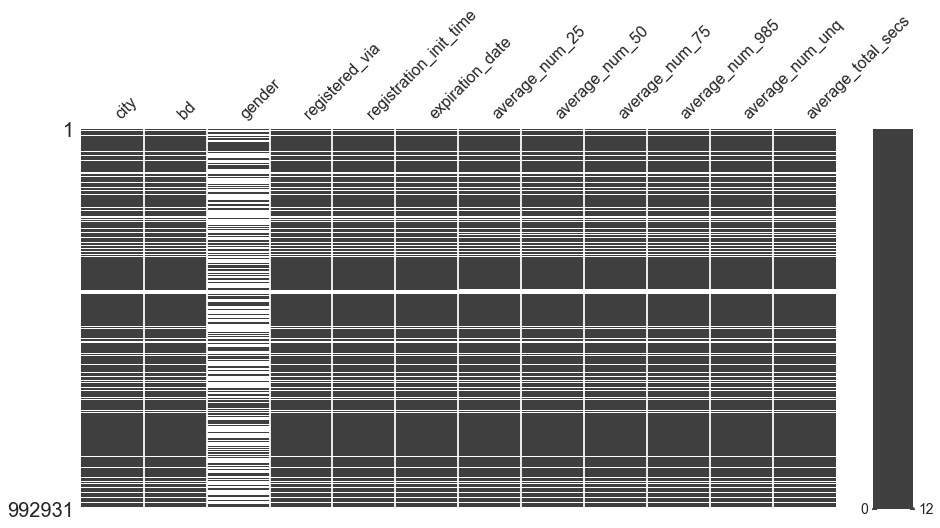

In [19]:
import missingno as msno

missing_columns = df_train.columns[df_train.isnull().any()].tolist()
msno.matrix(df_train[missing_columns], figsize=(15, 7))

In [22]:
df_test.shape

(970960, 17)

In [23]:
df_train.shape

(992931, 22)

In [19]:
df_train.drop(['gender'], axis=1, inplace=True)
df_test.drop(['gender'], axis=1, inplace=True)

In [20]:
df_train.fillna(value=df_train.mode()[0], inplace=True)
df_test.fillna(value=df_test.mode()[0], inplace=True)

### Feature Engineering

Time Interval Features

In [13]:
df_train['last_transaction_since_init'] = (df_train['transaction_date']-df_train['registration_init_time']).dt.days
df_test['last_transaction_since_init']  = (df_test['transaction_date']-df_test['registration_init_time']).dt.days

KeyError: 'registration_init_time'

In [ ]:
df_train['membership_duration'] = (df_train['membership_expire_date'] - df_train['transaction_date']).dt.days
df_test['membership_duration']  = (df_test['membership_expire_date'] - df_test['transaction_date']).dt.days

In [ ]:
df_train['registration_duration'] = (df_train['expiration_date'] - df_train['registration_init_time']).dt.days
df_test['registration_duration']  = (df_test['expiration_date'] - df_test['registration_init_time']).dt.days

Quantitative Features

In [ ]:
df_train['discount'] = (df_train['plan_list_price'] - df_train['actual_amount_paid'])
df_test['discount']  = (df_test['plan_list_price'] - df_test['actual_amount_paid'])

In [ ]:
df_train.drop(['transaction_date', 'membership_expire_date', 'expiration_date'], axis=1, inplace=True)
df_test.drop(['transaction_date', 'membership_expire_date', 'expiration_date'], axis=1, inplace=True)

Possible other features:
    
- Logs count

### Exploratory Analysis

In [14]:
df_train['msno'].nunique()

992931

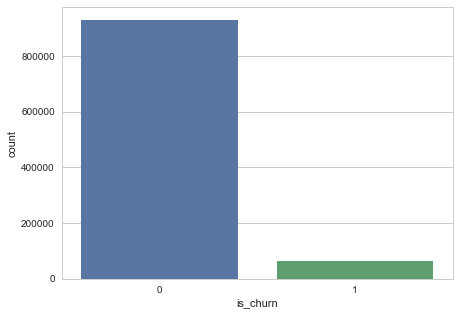

In [19]:
plt.figure(figsize=(7, 5))
sns.countplot(df_train['is_churn'])

Data is not balanced at all, as expected.

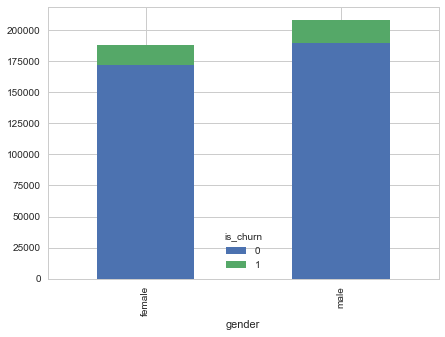

In [15]:
gender_crosstab = pd.crosstab(df_train['gender'], df_train['is_churn'])
gender_crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(7, 5))

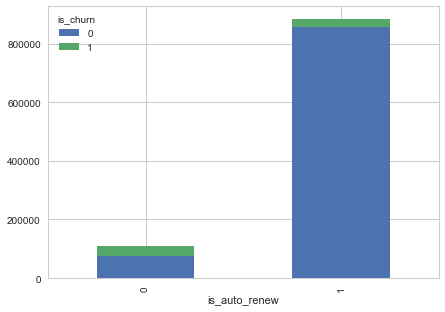

In [16]:
is_auto_renew_crosstab = pd.crosstab(df_train['is_auto_renew'], df_train['is_churn'])
is_auto_renew_crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(7, 5))

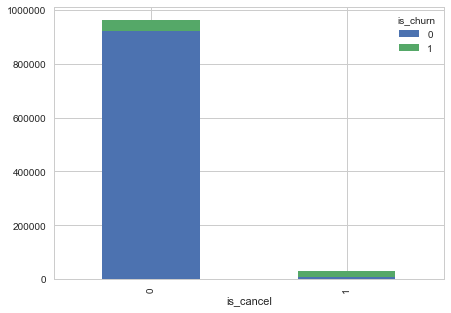

In [20]:
is_cancel_crosstab = pd.crosstab(df_train['is_cancel'], df_train['is_churn'])
is_cancel_crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(7, 5))

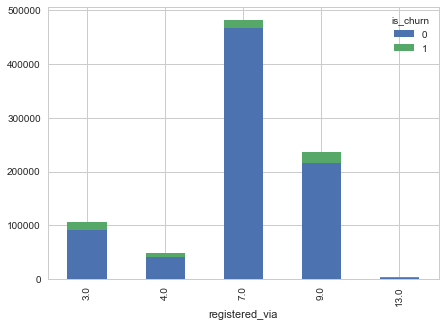

In [21]:
registered_via_crosstab = pd.crosstab(df_train['registered_via'], df_train['is_churn'])
registered_via_crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(7, 5))

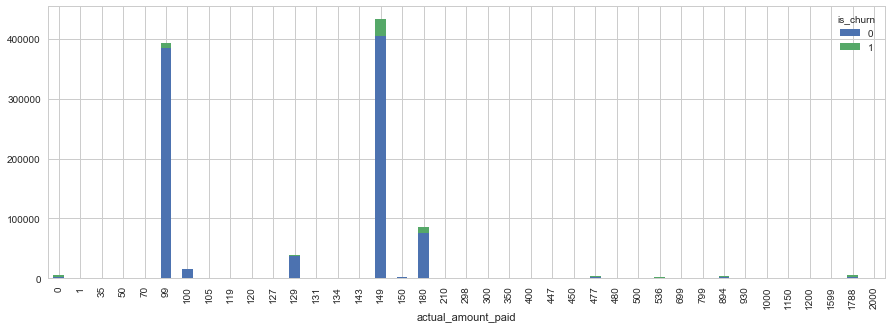

In [22]:
actual_amount_paid_crosstab = pd.crosstab(df_train['actual_amount_paid'], df_train['is_churn'])
actual_amount_paid_crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(15, 5))

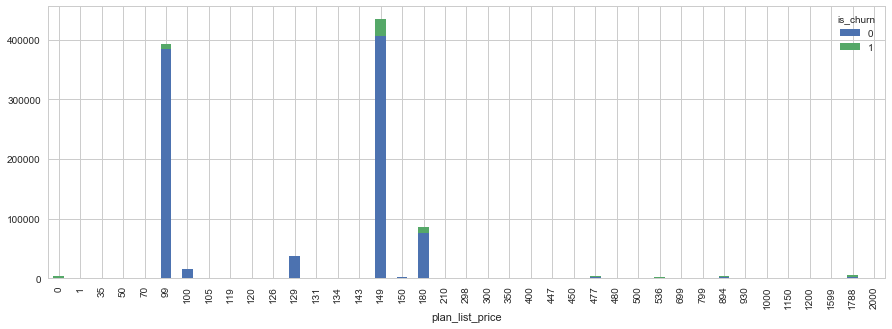

In [23]:
plan_list_price_crosstab = pd.crosstab(df_train['plan_list_price'], df_train['is_churn'])
plan_list_price_crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(15, 5))

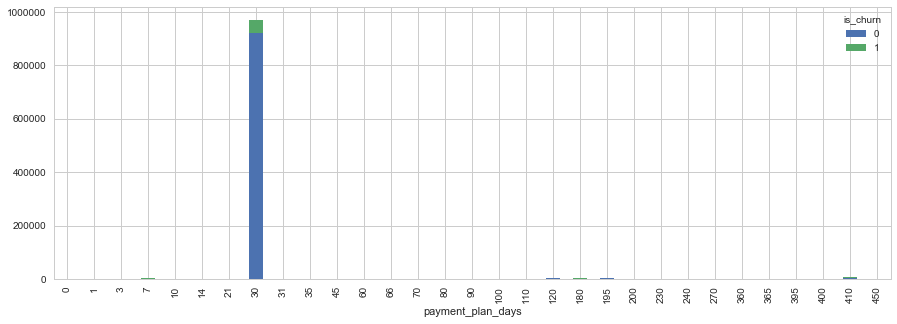

In [24]:
payment_plan_days_crosstab = pd.crosstab(df_train['payment_plan_days'], df_train['is_churn'])
payment_plan_days_crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(15, 5))

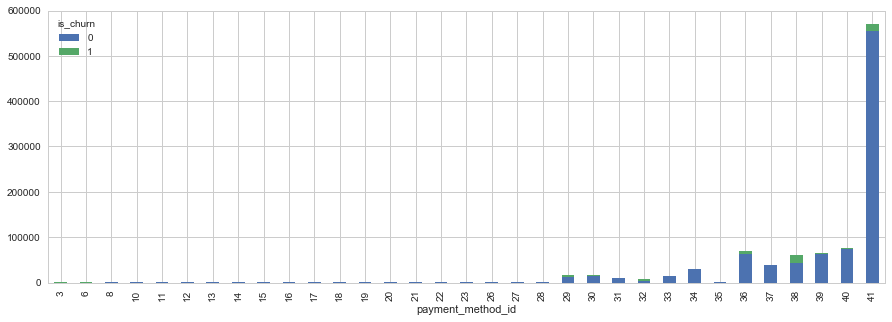

In [25]:
payment_method_id_crosstab = pd.crosstab(df_train['payment_method_id'], df_train['is_churn'])
payment_method_id_crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(15, 5))

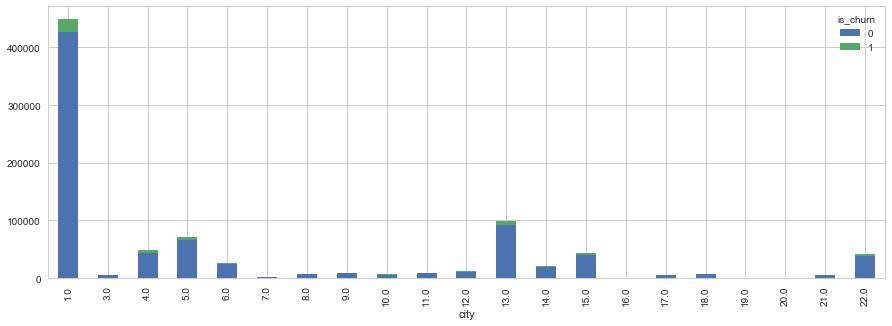

In [26]:
city_crosstab = pd.crosstab(df_train['city'], df_train['is_churn'])
city_crosstab.plot(kind='bar', stacked=True, grid=True, figsize=(15, 5))

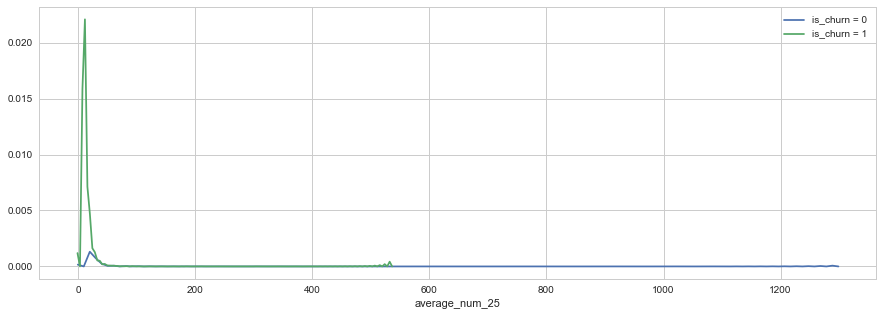

In [31]:
plt.figure(figsize=(15, 5))
sns.distplot(df_train[df_train['is_churn'] == 0]['average_num_25'].fillna(0).astype(int), hist=False, label='is_churn = 0')
sns.distplot(df_train[df_train['is_churn'] == 1]['average_num_25'].fillna(0).astype(int), hist=False, label='is_churn = 1')

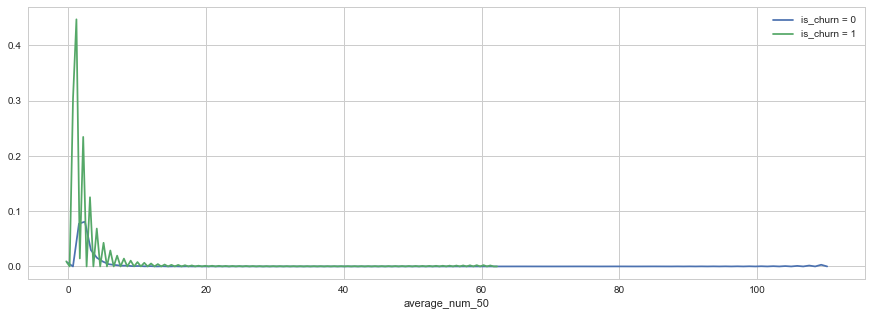

In [32]:
plt.figure(figsize=(15, 5))
sns.distplot(df_train[df_train['is_churn'] == 0]['average_num_50'].fillna(0).astype(int), hist=False, label='is_churn = 0')
sns.distplot(df_train[df_train['is_churn'] == 1]['average_num_50'].fillna(0).astype(int), hist=False, label='is_churn = 1')

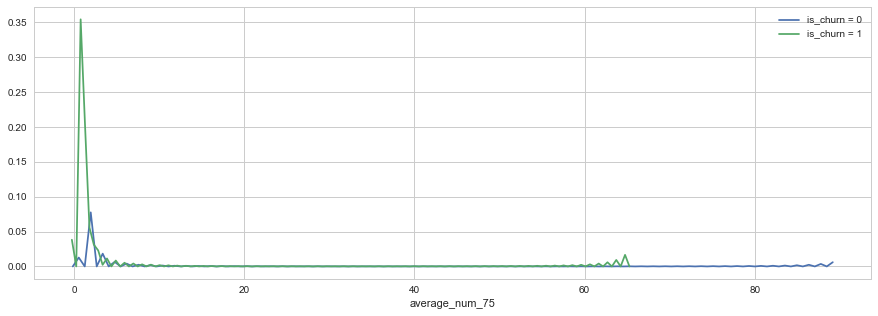

In [33]:
plt.figure(figsize=(15, 5))
sns.distplot(df_train[df_train['is_churn'] == 0]['average_num_75'].fillna(0).astype(int), hist=False, label='is_churn = 0')
sns.distplot(df_train[df_train['is_churn'] == 1]['average_num_75'].fillna(0).astype(int), hist=False, label='is_churn = 1')

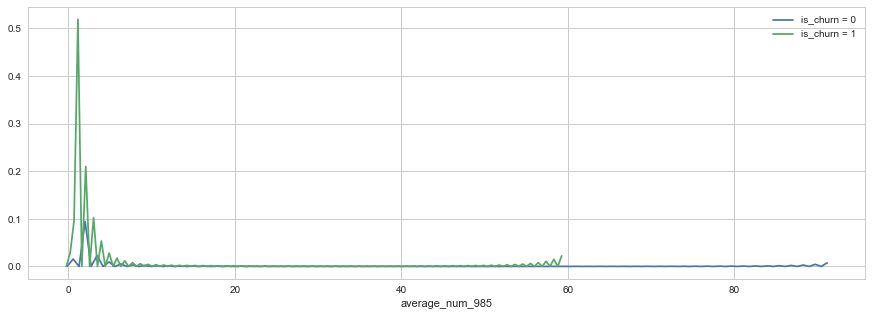

In [34]:
plt.figure(figsize=(15, 5))
sns.distplot(df_train[df_train['is_churn'] == 0]['average_num_985'].fillna(0).astype(int), hist=False, label='is_churn = 0')
sns.distplot(df_train[df_train['is_churn'] == 1]['average_num_985'].fillna(0).astype(int), hist=False, label='is_churn = 1')

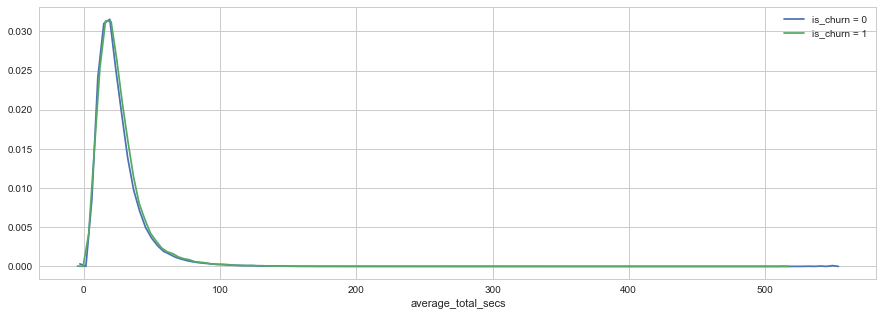

In [35]:
plt.figure(figsize=(15, 5))
sns.distplot(df_train[df_train['is_churn'] == 0]['average_total_secs'].fillna(0).astype(int), hist=False, label='is_churn = 0')
sns.distplot(df_train[df_train['is_churn'] == 1]['average_total_secs'].fillna(0).astype(int), hist=False, label='is_churn = 1')

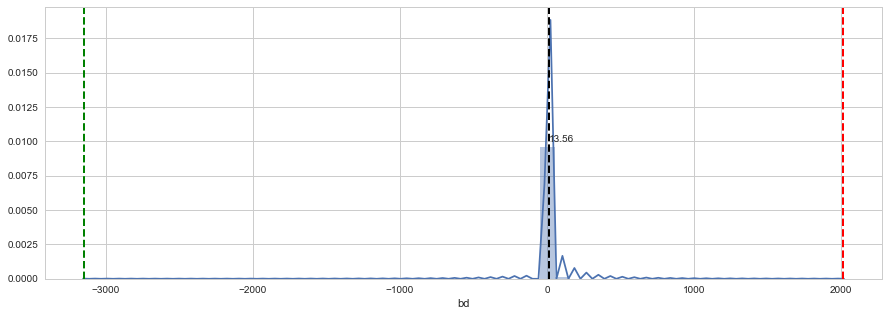

In [40]:
plt.figure(figsize=(15, 5))
sns.distplot(df_train['bd'].fillna(0), rug=False)
plt.axvline(df_train['bd'].min(),  color='g', linestyle='dashed', linewidth=2)
plt.axvline(df_train['bd'].max(),  color='r', linestyle='dashed', linewidth=2)
h = df_train['bd'].mean()
plt.axvline(h, color='k', linestyle='dashed', linewidth=2)
plt.annotate('{0:.2f}'.format(h),xy=(h+0.5, 0.01))

### Modeling

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [24]:
X_train = df_train.drop(['is_churn'], axis=1)
y_train = df_train['is_churn']
X_test  = df_test.drop(['is_churn'], axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

#### XGBoost

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
import xgboost as xgb

from sklearn.grid_search import GridSearchCV

C:\Users\paula.ceccon.ribeiro\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\paula.ceccon.ribeiro\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [ ]:
model = xgb.XGBClassifier(silent=1)
model_params = {
    'n_estimators':       [50, 100, 200, 300],
    'learning_rate':      [0.05, 0.1, 0.5],
    'max_depth':          [2, 3, 5, 10],
    'min_child_weight':   [1, 3, 5, 7],
    'subsample':          [0.3, 0.5, 0.8, 1.0],
    'colsample_bytree':   [0.3, 0.5, 0.7, 1.0],
    'colsample_bylevel':  [0.5, 0.7, 1.0]
}

grid = GridSearchCV(model, model_params, scoring='neg_log_loss', cv=5, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

print (grid.best_params_)

Fitting 5 folds for each of 9216 candidates, totalling 46080 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min


In [ ]:
model = xgb.XGBClassifier(silent=1, grid.best_params_).fit(X_train, y_train)

In [ ]:
scores = cross_val_score(model, X_test, y_test, cv=5)
print("Log Loss: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))